Homework 2

Harsh Bhatt (hb371)

# Generating Decision Trees

## Generating a dataset according to the given scheme

In [1]:
from random import choices
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Here we are generating dataset according to the scheme specified in question 1a.

class GenerateDataset:

    def __init__(self, k):
        self.weights, self.y_array, self.x_array = [], [], []
        
        # Generate Weights
        weight_sum = 0
        for i in range(2, k + 1):
            weight_sum += 0.9 ** i

        for i in range(2, k + 1):
            wi = (0.9 ** i) / weight_sum
            self.weights.append(wi)

    def generate_y_values(self, x_values, k):
        # According to the x values generated, we are generating the labels for a particular datapoint.
        check_sum = 0
        y = -1
        for i in range(1, k):
            check_sum += self.weights[i - 1] * x_values[i]
        if check_sum >= 0.5:
            y = x_values[0]
        else:
            y = 1 - x_values[0]
        return y

    def generate_data_points(self, k):
        # Generate x values for a row and subsequently generate the labels calling the above function.
        x_values = [choices([0, 1], [0.5, 0.5])[0]]

        for i in range(1, k):
            x_values.append(choices([x_values[i - 1], (1 - x_values[i - 1])], [0.75, 0.25])[0])
        y_value = self.generate_y_values(x_values, k)
        self.y_array.append(y_value)
        self.x_array.append(x_values)

    def generate(self, m, k):
        # Here we get the m and k values through which the dataset is generated.
        for i in range(m):
            self.generate_data_points(k)
        return np.array(self.x_array), np.array(self.y_array)
    
# An example of dataset generated with 4 features and 10 datapoints.
obj = GenerateDataset(4)
x, y = obj.generate(10, 4)
print(x) 
print(y)

[[1 1 1 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [1 0 0 1]
 [0 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 1]
 [1 1 0 0]]
[1 0 0 1 0 1 1 0 0 0]


## Creating a Decision Tree using ID3 algorithm

In [3]:
class Node:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None, entropy=None, samples=None,
                 counts=None):
        # Initializing the node class with a variety of values which helps us in representing numerous values easily. 
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name
        self.entropy = entropy
        self.samples = samples
        self.counts = counts


class DecisionTree:
    flag = "a"

    def __init__(self):
        self.root = None
    
    def train(self, x_array, y):
        _, features = x_array.shape
        self.root = self.tree(x_array, y)
    
    # Tree will grow using the below function.
    def tree(self, x_array, y):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        
        # Checking if only single valued labels are present,  
        if len_labels == 1:
            label_name = y[0]
            return Node(label_name=label_name)
        
        # Finding the column and value to split on using another function.
        feature_index, entropy, feature_value = self.get_split_index(x_array, y, np.unique(y))
        if entropy == 0:
            value = self.max_counter(y)
            return Node(label_name=value)
        
        # Splitting the array based on the values we got from the splitting function.
        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)
                
        # Creating left and right branches of the current node.
        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)])
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)])
        return Node(feature_index, feature_value, left=left_node, right=right_node, entropy=entropy,
                    samples=len(y), counts=np.bincount(y))
    
    # Counter function to split based on the counts of y values.
    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value
    
    # Looping over the indexes and value to find the one with highestn entropy.
    def get_split_index(self, x_array, y, unique_y):
        entropy, split_index, split_value = -1, None, None
        for column in range(x_array.shape[1]):
            X_column = x_array[:, column]
            for value in unique_y:
                gain = self.information_gain(X_column, y, value)
                if gain > entropy:
                    entropy = gain
                    split_index = column
                    split_value = value

        return split_index, entropy, split_value
    
    # Finding the IG for a given column and value.
    def information_gain(self, X_column, y, split_value):
        H_Y = self.H(y)

        left_indices, right_indices = [], []
        length = len(X_column)
        for i in range(length):
            if X_column[i] == split_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        y_length = len(y)
        H_Y_X = 0
        x_values = {len(left_indices): y[left_indices], len(right_indices): y[right_indices]}
        for value in x_values:
            x_probability = value / y_length
            H_Y_X += x_probability * self.H(x_values[value])

        IG = H_Y - H_Y_X
        return IG

    # Calculating the entropy using the formula taught.
    def H(self, y):
        counts = np.bincount(y)
        length_y = len(y)
        probabilities = np.array([i / length_y for i in counts])
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    # This function will be called when we want to predict. Requires us to pass the datapoints as the parameter.
    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])
    
    # Traversing the tree for the predict function.
    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)
    
    # Using BFS to print the decision tree level by level with details on which it was created.
    def print_tree(self, root):
        if root.feature is None and root.label_name is None:
            return
        
        print("Level 0 (Root Node) ")
        queue = [root, self.flag]

        while True:
            current = queue.pop(0)
            if current != "a":
                if current.label_name is not None:
                    print("Value = {}, Entropy = {}".format(current.label_name, current.entropy, end=" "))
                else:
                    print("Feature = {}, Samples = {}, Counts = {}, Entropy = {}".format(current.feature,
                                                                                         current.samples,
                                                                                         current.counts,
                                                                                         current.entropy, end=" "))
                if current.left is not None:
                    queue.append(current.left)
                if current.right is not None:
                    queue.append(current.right)
            else:
                if len(queue) == 0:
                    break
                else:
                    print("\nNext Level")
                    queue.append(self.flag)


In [5]:
#This is the function which will calculate the error from our actual data labels and the predicted labels.

def error(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return 1 - accuracy

In [6]:
# Creating a decision tree and finding the training error on it.
# Parameter passed here is k.
data_obj = GenerateDataset(4)
# Parameters passed here are m and k respectively.
x_train, y_train = data_obj.generate(30, 4)

clf = DecisionTree()
clf.train(x_train, y_train)

y_pred = clf.predict(x_train)
myerror = error(y_train, y_pred)

print("Error on training data is ", myerror)


Error on training data is  0.0


In [9]:
x, y = np.array([[0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,0,1,0]
,[0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,0,1]
,[0,1,1,1,1,1,1,0,1,1,0,0,1,1,1,1,0,0,1,1,0]
,[0,0,0,1,1,1,1,1,1,0,0,0,0,1,1,0,1,0,0,1,1]
,[1,1,1,1,1,1,0,1,0,0,0,0,1,1,1,1,1,0,1,1,0]
,[1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,0,1]
,[0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0]
,[1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,1,1,0,0,0,1]
,[0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1]
,[1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,0,1]]), np.array([1,0,1,1,0,1,1,1,1,1])
clf.train(x, y)
clf.print_tree(clf.root)

Level 0 (Root Node) 
Feature = 11, Samples = 10, Counts = [2 8], Entropy = 0.36096404744368116

Next Level
Feature = 6, Samples = 5, Counts = [1 4], Entropy = 0.7219280948873623
Feature = 2, Samples = 5, Counts = [1 4], Entropy = 0.7219280948873623

Next Level
Value = 0, Entropy = None
Value = 1, Entropy = None
Value = 0, Entropy = None
Value = 1, Entropy = None


## Generation of data and fit a decision tree

In [7]:
# Creating a decision tree and printing the nodes by level.

data_obj = GenerateDataset(4)
x_train, y_train = data_obj.generate(30, 4)

clf = DecisionTree()
clf.train(x_train, y_train)

print(x_train, y_train)
clf.print_tree(clf.root)

[[0 0 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 0 0 0]
 [1 0 1 1]
 [0 1 1 1]
 [1 1 1 0]
 [0 0 1 1]
 [1 1 1 1]
 [1 0 1 1]
 [0 1 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 1]
 [1 1 1 0]
 [1 0 0 0]
 [1 1 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 1 1]
 [1 0 0 1]
 [1 1 1 1]
 [0 1 1 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 1]] [0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1]
Level 0 (Root Node) 
Feature = 3, Samples = 30, Counts = [11 19], Entropy = 0.11699190804451032

Next Level
Feature = 0, Samples = 16, Counts = [ 3 13], Entropy = 0.2651749506101608
Feature = 0, Samples = 14, Counts = [8 6], Entropy = 0.23612234796179477

Next Level
Value = 1, Entropy = None
Feature = 2, Samples = 7, Counts = [3 4], Entropy = 0.9852281360342515
Feature = 2, Samples = 9, Counts = [7 2], Entropy = 0.45810589515712374
Feature = 2, Samples = 5, Counts = [1 4], Entropy = 0.7219280948873623

Next Level
Value = 0, Entropy = None
Value = 1, Entropy = None
Feature = 1, Samples = 3, Counts = [

The ordering matters as the feature with highest IG is chosen at first. As we go down, we have comparatively "pure" data so we expect higher entropy. But if we swap a feature down the branch with one of its parent, then the distribution of data points based on that feature would not be optimal. Hence our decision tree would not give out accurate results.

![title](image.JPG)

## Find the typical (Average) error

In [61]:
#Function to calculate averge error
def average_error(y):
    total, average = 0, 0
    for i in y:
        total += i
    average = total / len(y)
    return average * 100

# As we have fit a decision tree in the previous question, we would just use that tree to test our data now.
y = []
i = 0
while i <= 200:
    
    new_obj = GenerateDataset(4)
    x_test, y_test = new_obj.generate(2000, 4)
    
    y_pred = clf.predict(x_test)
    acc = error(y_test, y_pred)
    y.append(acc)
    
    i += 1

print("Some original labels: {}, Corresponding Predictions: {}".format(y_test[:10], y_pred[:10]))
print("Average Error = {}%".format(average_error(y)))

[0 0 0 1 1 1 1 0 1 0] [0 0 0 1 1 1 1 0 1 0]
Average Error = 4.673631840796021%


As we can see from above, the average error is = 4.67%

## For k = 10, finding error and making graph

In [8]:
def graph(x, y):
    plt.plot(x, y, label="ID3 ", color="red")
    plt.xlabel("m values")
    plt.ylabel(" $|err_{test} - err_{train}|$")
    plt.title("ID3")
    plt.legend()
    plt.show()


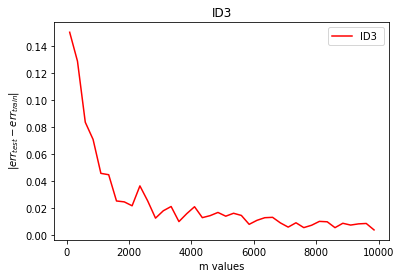

In [89]:
x, y = [], []
for i in range(100, 10000, 250):
    data_obj = GenerateDataset(10)
    x_dataset, y_dataset = data_obj.generate(i, 10)
    x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTree()
    clf.train(x_train, y_train)

    y_pred = clf.predict(x_test)
    acc = error(y_test, y_pred)

    y_train_pred = clf.predict(x_train)
    acc1 = error(y_train, y_train_pred)

    y.append(abs(acc - acc1))
    x.append(i)

graph(x, y)

We can say by looking at the graph that as we have more number of training datapoints, our decision tree that is bulit understands the underlying distribution of data very well.

## Alternative Metric - Gini Index

In [10]:
class Node_gini:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None, entropy=None, samples=None,
                 counts=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name
        self.entropy = entropy
        self.samples = samples
        self.counts = counts


class DecisionTree_gini:
    flag = "a"

    def __init__(self):
        self.root = None

    def train(self, x_array, y):
        _, features = x_array.shape
        indices = [i for i in range(features)]
        self.root = self.tree(x_array, y, indices)

    def tree(self, x_array, y, feature_indices):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        if len_labels == 1:
            label_name = y[0]
            return Node_gini(label_name=label_name)

        if len_labels != 1 and len(feature_indices) == 0:
            value = self.max_counter(y)
            return Node_gini(label_name=value)

        indexes = feature_indices
        feature_index, entropy, feature_value = self.get_split_index(x_array, y, indexes, np.unique(y))
        if entropy == 0:
            value = self.max_counter(y)
            return Node_gini(label_name=value)

        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)], indexes)
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)], indexes)
        return Node_gini(feature_index, feature_value, left=left_node, right=right_node, entropy=entropy,
                    samples=len(y), counts=np.bincount(y))

    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value

    def get_split_index(self, x_array, y, indexes, unique_y):
        best_gain, split_index, split_value = 0, None, None
        for column in indexes:
            X_column = x_array[:, column]
            left, right = np.array([]), np.array([])
            for value in unique_y:
                for i in range(len(X_column)):
                    if X_column[i] == value:
                        np.append(left, i)
                    else:
                        np.append(right, i)

                if len(left) == 0 or len(right) == 0:
                    continue

                gain = self.information_gain(left, right)
                if gain < best_gain:
                    best_gain = gain
                    split_index = column
                    split_value = value

        return split_index, best_gain, split_value
    
    # This is the information gain which we would get for gini index.
    def information_gain(self, left, right):
        probability = len(left) / (len(left) + len(right))
        return (probability * self.gini(left)) - ((1-probability) * self.gini(right))
    
    # The gini index calculation is done here where we just pass the required row.
    def gini(self, rows):
        length = len(rows)
        counts = np.bincount(rows)
        impurity = 1
        for i in range(len(counts)):
            prob = counts[i] / length
            impurity -= prob**2
        return impurity

    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])

    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)

Testing gini on dataset

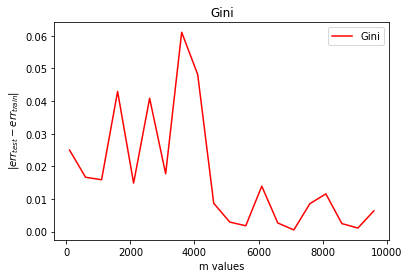

In [90]:
def gini_graph(x, y):
    plt.plot(x, y, label="Gini", color="red")
    plt.xlabel("m values")
    plt.ylabel(" $|err_{test} - err_{train}|$")
    plt.title("Gini")
    plt.legend()
    plt.show()

gx, gy = [], []
for i in range(100, 10000, 500):
    data_obj = GenerateDataset(10)
    gx_dataset, gy_dataset = data_obj.generate(i, 10)
    gx_train, gx_test, gy_train, gy_test = train_test_split(gx_dataset, gy_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTree_gini()
    clf.train(gx_train, gy_train)

    gy_pred = clf.predict(gx_test)
    acc = error(gy_test, gy_pred)

    gy_train_pred = clf.predict(gx_train)
    acc1 = error(gy_train, gy_train_pred)

    gy.append(abs(acc - acc1))
    gx.append(i)

gini_graph(gx, gy)

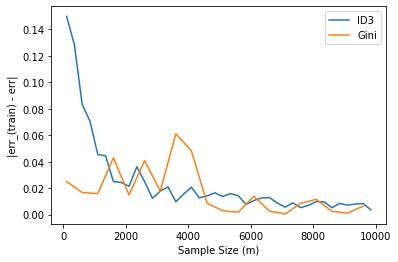

In [91]:
plt.plot(x,y)
plt.plot(gx, gy)
plt.xlabel("Sample Size (m)")
plt.ylabel("|err_(train) - err|")
plt.legend(["ID3", "Gini"])
plt.show()

We can compare the two methods using the above graph. As we see, the error for both metrics is almost same but the error for Gini Index starts very high and then it keeps fluctuating in a small range of errors. The final probability is almost same for both the metrics, with Gini being slightly better, when the sample size is maximum for the given iteration.

# Pruning Decision Trees

## Generating dataset by a scheme

In [3]:
class GenerateDataset2:
    def __init__(self):
        self.x_array, self.y_array = [], []
        
    def generate_y_values(self, x_values):
        if x_values[0] == 0:
            y = Counter(x_values[1:6]).most_common()[0][0]
        else:
            y = Counter(x_values[6:11]).most_common()[0][0]
        return y

    def generate_data_points(self):
        # Updated datapoints generation.
        x_values = [choices([0, 1], [0.5, 0.5])[0]]

        for i in range(1, 11):
            x_values.append(choices([x_values[i - 1], (1 - x_values[i - 1])], [0.75, 0.25])[0])
        for i in range(11, 16):
            x_values.append(choices([1, 0], [0.5, 0.5])[0])
        y_value = self.generate_y_values(x_values)
        self.x_array.append(x_values)
        self.y_array.append(y_value)
        
    def generate(self, m):
        for i in range(m):
            self.generate_data_points()
        return np.array(self.x_array), np.array(self.y_array)

In [35]:
# Same function as the ID3. Added two functions at the end to find the irrelevant variables.
class Node2:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name


class DecisionTree2:
    flag = "a"

    def __init__(self):
        self.root = None
        self.irrelevant_array, self.total_array = [], []
        self.ir, self.total = 0, 0

    def train(self, x_array, y):
        _, features = x_array.shape
        indices = [i for i in range(features)]
        self.root = self.tree(x_array, y)

    def tree(self, x_array, y):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        if len_labels == 1:
            label_name = y[0]
            return Node2(label_name=label_name)

        if len_labels == 1:
            value = self.max_counter(y)
            return Node2(label_name=value)

        feature_index, entropy, feature_value = self.get_split_index(x_array, y, np.unique(y))
        
        self.total_array.append(feature_index)
        self.total += 1
        
        # Counting the irrelevant variables in our tree.
        if feature_index in [11, 12, 13, 14, 15]:
            print(feature_index)
            self.ir += 1
            self.irrelevant_array.append(feature_index)
                
        if entropy == 0:
            value = self.max_counter(y)
            return Node2(label_name=value)

        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)])
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)])
        return Node2(feature_index, feature_value, left=left_node, right=right_node)

    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value

    def get_split_index(self, x_array, y, unique_y):
        entropy, split_index, split_value = -1, None, None
        length = x_array.shape[1]
        for column in range(length):
            X_column = x_array[:, column]
            for value in unique_y:
                gain = self.information_gain(X_column, y, value)
                if gain > entropy:
                    entropy = gain
                    split_index = column
                    split_value = value

        return split_index, entropy, split_value

    def information_gain(self, X_column, y, split_value):
        H_Y = self.H(y)

        left_indices, right_indices = [], []
        length = len(X_column)
        for i in range(length):
            if X_column[i] == split_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        y_length = len(y)
        H_Y_X = 0
        x_values = {len(left_indices): y[left_indices], len(right_indices): y[right_indices]}
        for value in x_values:
            x_probability = value / y_length
            H_Y_X += x_probability * self.H(x_values[value])

        IG = H_Y - H_Y_X
        return IG

    def H(self, y):
        counts = np.bincount(y)
        length_y = len(y)
        probabilities = np.array([i / length_y for i in counts])
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])

    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)

    # The functions to find unique irrelevant variables and the probability of irrelevant variables respectively.
    def check_irrelevant(self):
        print(self.ir, self.total)
    
    def check_irrelevant_probability(self):
        return self.ir
    
    def print_tree(self, root):
        if root.feature is None and root.label_name is None:
            return
        
        print("Level 0 (Root Node) ")
        queue = [root, self.flag]

        while True:
            current = queue.pop(0)
            if current != "a":
                if current.label_name is not None:
                    print("Value = {}".format(current.label_name, end=" "))
                else:
                    print("Feature = {}".format(current.feature, end=" "))
                if current.left is not None:
                    queue.append(current.left)
                if current.right is not None:
                    queue.append(current.right)
            else:
                if len(queue) == 0:
                    break
                else:
                    print("\nNext Level")
                    queue.append(self.flag)

In [30]:
ax, ay = [], []
for i in range(50, 10000, 250):
    absolute_error = 0
    '''
    We run iteration for a particular value of m for 5 times to find the error rate and average it to get the typical
    error for a particular m. And finally, we plot the average error for a particular m.
    '''
    for k in range(0,5):
        data_obj = GenerateDataset2()
        ax_dataset, ay_dataset = data_obj.generate(i)
        ax_train, ax_test, ay_train, ay_test = train_test_split(ax_dataset, ay_dataset, test_size=0.2, random_state=1234)

        clf = DecisionTree2()
        clf.train(ax_train, ay_train)

        ay_pred = clf.predict(ax_test)
        acc = error(ay_test, ay_pred)

        ay_train_pred = clf.predict(ax_train)
        acc1 = error(ay_train, ay_train_pred)

        absolute_error += abs(acc - acc1)
        
    # Finding average error for m.    
    ay.append(absolute_error/5)
    ax.append(i)

plt.plot(ax,ay)
plt.legend(["ID3"])
plt.xlabel("Sample size (m)")
plt.ylabel("Average error rate")
plt.show()

15
15
13
14
11
13
13
14
15
13
11
12
13
12
15
13
12
15
13
12
14
11
13
14
11
14
14
12
15
12
13
12
14
12
14
12
13
12
14
15
13
15
12
13
14
15
13
14
11
15
14
12
13
11
14
12
14
11
14
13
15
15
11
14
12
13
14
11
12
12
11
12
11
11
12
13
15
13
12
13
12
14
15
13
13
11
12
12
14
12
11
11
15
12
15
14
11
11
12
14
13
13
12
14
11
13
12
15
13
14
12
11
12
13
14
13
13
11
14
14
11
12
14
15
12
15
11
11
12
14
14
12
11
15
13
12
12
14
12
14
14
13
15
11
15
12
12
15
12
11
14
11
13
14
15
15
13
12
11
14
13
11
15
12
15
11
13
12
11
13
11
13
15
12
11
13
14
11
14
14
11
12
14
15
11
14
13
15
11
12
15
11
15
14
11
13
11
13
12
11
15
13
14
15
13
14
11
13
11
11
15
12
13
14
12
12
12
14
13
12
15
12
15
11
11
12
14
13
15
14
13
13
15
15
11
13
11
12
11
12
14
15
12
14
15
14
15
11
14
12
13
11
13
12
11
15
12
11
14
12
14
11
15
13
12
12
11
11
14
11
12
12
11
15
14
14
13
11
13
12
12
11
11
12
14
13
14
12
15
11
13
15
14
13
12
13
12
14
11
12
15
15
12
14
13
13
11
11
14
14


KeyboardInterrupt: 

We can agree with this intuition that after getting more datapoints to train, the algorithm gets better.After we got the sample values for around 4000, our error rate stabilized a bit. So getting more datapoints helped in our algorithm to learn better.

## Irrelevant variables included in the tree

In [31]:
probability, count = [], []
it = [j for j in range(10, 50000, 1000)]
for i in range(10, 50000, 1000):
    count_prob, count_num, count_total = 0, 0, 0
    for k in range(5):
        data_obj = GenerateDataset2()
        x_dataset, y_dataset = data_obj.generate(i)
        x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

        clf = DecisionTree2()
        clf.train(x_train, y_train)
                  
#         irr_num = clf.check_irrelevant()
#         count_num += irr_num
        ip = clf.check_irrelevant_probability()
        count_prob += ip
#     count.append(count_num/5)
    print("New Iteration")
    probability.append(count_prob/5)
                  
# print("Average number of irrelevant variables in the decision tree: {}".format(sum(count)/len(count)))
print("Average probability of including an irrelevant variable in the decision tree: {}".format(sum(probability)/len(probability)))

# plt.plot(it,probability)
# plt.xlabel("Sample Size")
# plt.ylabel("Random Variables Probability")
# plt.show()

New Iteration
13
15
11
14
11
14
11
13
14
14
11
13
13
14
13
14
13
12
12
15
11
13
14
15
11
12
15
14
13
12
13
11
12
15
14
14
15
11
13
15
13
12
15
13
15
12
15
12
12
12
15
11
11
13
12
New Iteration
15
11
12
12
15
14
12
13
13
11
11
12
11
15
11
14
14
13
11
12
12
15
11
12
11
14
13
11
15
14
11
11
13
13
12
11
14
11
14
11
14
13
13
12
15
12
13
14
13
11
12
14
15
11
14
13
14
13
New Iteration
15
13
11
13
13
11
12
11
15
11
12
11
13
12
14
13
15
14
11
12
12
11
14
12
11
13
11
15
11
13
15
14
11
15
15
14
11
15
11
11
13
15
12
15
13
14
13
14
11
12
13
11
12
13
15
12
11
12
15
12
12
13
14
11
11
14
New Iteration
14
15
11
15
12
11
13
12
14
13
11
15
13
11
12
13
11
12
14
12
11
12
14
11
13
13
11
15
13
12
15
14
14
15
11
15
13
15
15
15
13
14
11
13
13
14
15
13
11
13
13
11
13
13
11
13
12
New Iteration
15
14
14
14
13
11
12
13
12
12
12
11
13
14
13
15
14
13
13
12
13
11
12
14
14
11
11
15
14
15
14
14
11
12
12
15
11
12
11
14
14
15
14
15
11
14
11
12
15
New Iteration
12
15
15


KeyboardInterrupt: 

In [36]:
probability, count = [], []
it = [j for j in range(10, 50000, 1000)]
count_prob, count_num, count_total = 0, 0, 0
data_obj = GenerateDataset2()
x_dataset, y_dataset = data_obj.generate(5000)
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

clf = DecisionTree2()
clf.train(x_train, y_train)

clf.print_tree(clf.root)
                  
# print("Average number of irrelevant variables in the decision tree: {}".format(sum(count)/len(count)))

# plt.plot(it,probability)
# plt.xlabel("Sample Size")
# plt.ylabel("Random Variables Probability")
# plt.show()

15
13
12
11
11
11
11
Level 0 (Root Node) 
Feature = 8

Next Level
Feature = 3
Feature = 0

Next Level
Feature = 6
Feature = 0
Feature = 3
Feature = 7

Next Level
Feature = 5
Feature = 9
Feature = 5
Feature = 10
Feature = 2
Feature = 5
Feature = 10
Feature = 9

Next Level
Feature = 4
Feature = 2
Feature = 1
Feature = 0
Feature = 1
Feature = 11
Feature = 9
Feature = 6
Feature = 1
Feature = 1
Feature = 2
Feature = 4
Feature = 6
Feature = 9
Feature = 6
Value = 1

Next Level
Feature = 7
Feature = 2
Feature = 1
Feature = 0
Feature = 2
Feature = 2
Feature = 7
Feature = 10
Feature = 2
Feature = 2
Feature = 4
Feature = 4
Value = 0
Feature = 7
Feature = 7
Feature = 9
Value = 0
Feature = 4
Feature = 5
Feature = 4
Feature = 1
Feature = 1
Feature = 2
Value = 1
Value = 0
Feature = 9
Feature = 6
Value = 1
Feature = 10
Value = 1

Next Level
Value = 0
Feature = 9
Value = 0
Feature = 0
Value = 0
Feature = 0
Feature = 15
Value = 0
Feature = 0
Feature = 5
Feature = 13
Feature = 10
Feature = 11
Feature = 4

In [ ]:
probability, count = [], []
it = [j for j in range(10, 50000, 1000)]
for i in range(10, 50000, 1000):
    count_prob, count_num = 0, 0
    for k in range(5):
        data_obj = GenerateDataset2()
        x_dataset, y_dataset = data_obj.generate(i)
        x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

        clf = DecisionTree2()
        clf.train(x_train, y_train)
                  
        irr_num = clf.check_irrelevant()
        count_num += irr_num
        ip = clf.check_irrelevant_probability()
        count_prob += ip
    count.append(count_num/5)
    probability.append(count_prob/5)
                  
print("Average number of irrelevant variables in the decision tree: {}".format(sum(count)/len(count)))
print("Average probability of including an irrelevant variable in the decision tree: {}".format(sum(probability)/len(probability)))

plt.plot(it,probability)
plt.xlabel("Sample Size")
plt.ylabel("Random Variables Probability")
plt.show()

In [105]:
probability, count = [], []
it = [j for j in range(10, 50000, 1000)]
for i in range(2000, 14001, 2000):
    count_prob, count_num = 0, 0
    for k in range(1):
        data_obj = GenerateDataset2()
        x_dataset, y_dataset = data_obj.generate(i)
        x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

        clf = DecisionTree2()
        clf.train(x_train, y_train)
                  
        irr_num = clf.check_irrelevant()
        count_num += irr_num
        ip = clf.check_irrelevant_probability()
        count_prob += ip
    count.append(count_num/5)
    probability.append({i:count_prob})
print("m values and probabilities are: ",probability)
                  
# print("Average number of irrelevant variables in the decision tree: {}".format(sum(count)/len(count)))
# print("Average probability of including an irrelevant variable in the decision tree: {}".format(sum(probability)/len(probability)))

# plt.plot(it,probability)
# plt.xlabel("Sample Size")
# plt.ylabel("Random Variables Probability")
# plt.show()

m values and probabilities are:  [{2000: 0.10112359550561797}, {4000: 0.058823529411764705}, {6000: 0.10483870967741936}, {8000: 0.06716417910447761}, {10000: 0.08461538461538462}, {12000: 0.06086956521739131}, {14000: 0.05263157894736842}]


#### change this
For my algorithm, I am getting an average number of 6 irrelevant datapoints in my tree. In our dataset generation, we 6 features which are irrelevant i.e. from feature 11 to 20. So, the maximum number of irrelevant features a decision tree can have is 6. 

We see that at around 35000 datapoints, our model will not give any irrelevant features or the value would be lower than 1. And as have 15 relevant features in our dataset i.e. 0 to 14, so the number of relevant datapoints would be 2^15 = 32000. The answer is similar to the reasoning hence we can say that 35000 datapoints is required for no irrelevant data.

## Pruning by Depth

In [80]:
class NodeDepth:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None, entropy=None, samples=None,
                 counts=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name
        self.entropy = entropy
        self.samples = samples
        self.counts = counts

class DecisionTreeDepth:
    flag = "a"

    def __init__(self, max_depth):
        self.root = None
        self.max_depth = max_depth
        self.irrelevant_array, self.relevant_array = [], []
        self.ir, self.total = 0, 0

    def train(self, x_array, y):
        _, features = x_array.shape
        indices = [i for i in range(features)]
        self.root = self.tree(x_array, y)

    '''
    Here, I have passed a depth parameter which would be increased for each run. If the current depth equals this value,
    then we give the value my majority vote.
    '''
    def tree(self, x_array, y, depth = 0):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        if len_labels == 1:
            label_name = y[0]
            return NodeDepth(label_name=label_name)
        
        # Checking here if the current depth of the tree is equal to the parameter passed.
        if len_labels == 1 or depth >= self.max_depth:
            value = self.max_counter(y)
            return NodeDepth(label_name = value)

        feature_index, entropy, feature_value = self.get_split_index(x_array, y, np.unique(y))
        
        self.relevant_array.append(feature_index)
        self.total += 1
        
        if feature_index in [11, 12, 13, 14, 15]:
            self.ir += 1
            self.irrelevant_array.append(feature_index)
            
        if entropy == 0:
            value = self.max_counter(y)
            return NodeDepth(label_name=value)

        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)], depth+1)
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)], depth+1)
        return NodeDepth(feature_index, feature_value, left=left_node, right=right_node, entropy=entropy,
                    samples=len(y), counts=np.bincount(y))

    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value

    def get_split_index(self, x_array, y, unique_y):
        entropy, split_index, split_value = -1, None, None
        length = x_array.shape[1]
        for column in range(length):
            X_column = x_array[:, column]
            for value in unique_y:
                gain = self.information_gain(X_column, y, value)
                if gain > entropy:
                    entropy = gain
                    split_index = column
                    split_value = value

        return split_index, entropy, split_value

    def information_gain(self, X_column, y, split_value):
        H_Y = self.H(y)

        left_indices, right_indices = [], []
        length = len(X_column)
        for i in range(length):
            if X_column[i] == split_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        y_length = len(y)
        H_Y_X = 0
        x_values = {len(left_indices): y[left_indices], len(right_indices): y[right_indices]}
        for value in x_values:
            x_probability = value / y_length
            H_Y_X += x_probability * self.H(x_values[value])

        IG = H_Y - H_Y_X
        return IG

    def H(self, y):
        counts = np.bincount(y)
        length_y = len(y)
        probabilities = np.array([i / length_y for i in counts])
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])

    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)

    def check_irrelevant(self):
        return len(set(self.irrelevant_array))
    
    def check_irrelevant_probability(self):
        return self.ir/self.total

In [65]:
x, y, z = [], [], []
it = [i for i in range(0, 15)]
for i in range(0, 15):
    data_obj = GenerateDataset2()
    x_dataset, y_dataset = data_obj.generate(10000)
    x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTreeDepth(i)
    clf.train(x_train, y_train)

    y_pred = clf.predict(x_test)
    acc = 100*error(y_test, y_pred)

    y_train_pred = clf.predict(x_train)
    acc1 = 100*error(y_train, y_train_pred)

    y.append(acc)
    z.append(acc1)

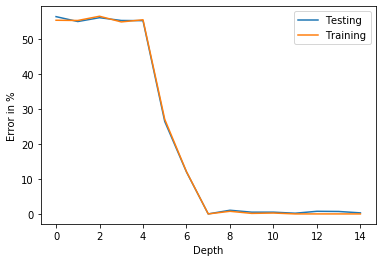

In [66]:
plt.plot(it,y)
plt.plot(it, z)
plt.xlabel("Depth")
plt.ylabel("Error in %")
plt.legend(["Testing", "Training"])
plt.show()

From the graph, we can see that after depth of around 8, the line for testing error flattens a bit. This is due to the intuition that as we have 15 relevant features and if we consider the relevant features only, then, our error could be minimized. But, if we consider all of the relevant variables, then it might overfit the data. As a result, 10 could be good depth to limit the tree. And, we see if the depth is 0-6, it does not consider lot of variables and as a result gives much error.

## Pruning by Sample Size

In [91]:
class NodeSample:
    def __init__(self, feature=None, value=None, *, left=None, right=None, label_name=None, entropy=None, samples=None,
                 counts=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label_name = label_name
        self.entropy = entropy
        self.samples = samples
        self.counts = counts


class DecisionTreeSample:
    flag = "a"

    def __init__(self, min_sample):
        self.root = None
        self.min_sample = min_sample
        self.irrelevant_array, self.relevant_array = [], []
        self.ir, self.total = 0, 0

    def train(self, x_array, y):
        _, features = x_array.shape
        indices = [i for i in range(features)]
        self.root = self.tree(x_array, y)

    def tree(self, x_array, y):
        left_indices, right_indices = [], []
        len_labels = len(set(y))
        
        if len_labels == 1 or len(y) <= self.min_sample:
            value = self.max_counter(y)
            return NodeSample(label_name = value)

        feature_index, entropy, feature_value = self.get_split_index(x_array, y, np.unique(y))
        
        self.relevant_array.append(feature_index)
        self.total += 1
        
        if feature_index in [11, 12, 13, 14, 15]:
            self.ir += 1
            self.irrelevant_array.append(feature_index)
            
        if entropy == 0:
            value = self.max_counter(y)
            return NodeSample(label_name=value)

        x_column = x_array[:, feature_index]
        len_x_column = len(x_column)
        for i in range(len_x_column):
            if x_column[i] == feature_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        left_node = self.tree(x_array[np.array(left_indices), :], y[np.array(left_indices)])
        right_node = self.tree(x_array[np.array(right_indices), :], y[np.array(right_indices)])
        return NodeSample(feature_index, feature_value, left=left_node, right=right_node, entropy=entropy,
                    samples=len(y), counts=np.bincount(y))

    def max_counter(self, y):
        counts = np.bincount(y)
        length = len(counts)
        max_count, max_value = -1, -1
        for i in range(length):
            if counts[i] > max_count:
                max_value = i
        return max_value

    def get_split_index(self, x_array, y, unique_y):
        entropy, split_index, split_value = -1, None, None
        length = x_array.shape[1]
        for column in range(length):
            X_column = x_array[:, column]
            for value in unique_y:
                gain = self.information_gain(X_column, y, value)
                if gain > entropy:
                    entropy = gain
                    split_index = column
                    split_value = value

        return split_index, entropy, split_value

    def information_gain(self, X_column, y, split_value):
        H_Y = self.H(y)

        left_indices, right_indices = [], []
        length = len(X_column)
        for i in range(length):
            if X_column[i] == split_value:
                left_indices.append(i)
            else:
                right_indices.append(i)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        y_length = len(y)
        H_Y_X = 0
        x_values = {len(left_indices): y[left_indices], len(right_indices): y[right_indices]}
        for value in x_values:
            x_probability = value / y_length
            H_Y_X += x_probability * self.H(x_values[value])

        IG = H_Y - H_Y_X
        return IG

    def H(self, y):
        counts = np.bincount(y)
        length_y = len(y)
        probabilities = np.array([i / length_y for i in counts])
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def predict(self, x_array):
        return np.array([self.tree_traverse(x, self.root) for x in x_array])

    def tree_traverse(self, x, node):
        if node.label_name is not None:
            return node.label_name

        if x[node.feature] == node.value:
            return self.tree_traverse(x, node.left)
        return self.tree_traverse(x, node.right)

    def check_irrelevant(self):
        return len(set(self.irrelevant_array))
    
    def check_irrelevant_probability(self):
        if self.total == 0:
            return 0
        return self.ir/self.total

In [93]:
x, y, z = [], [], []
it = [i for i in range(0, 10000, 250)]
for i in range(0, 10000, 250):
    data_obj = GenerateDataset2()
    x_dataset, y_dataset = data_obj.generate(10000)
    x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTreeSample(i)
    clf.train(x_train, y_train)

    y_pred = clf.predict(x_test)
    acc = 100*error(y_test, y_pred)

    y_train_pred = clf.predict(x_train)
    acc1 = 100*error(y_train, y_train_pred)

    y.append(acc)
    z.append(acc1)

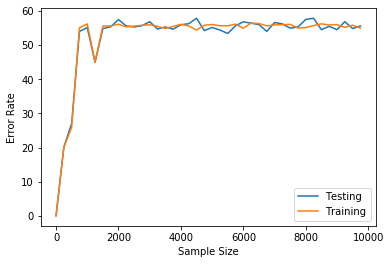

In [94]:
plt.plot(it,y)
plt.plot(it, z)
plt.xlabel("Sample Size")
plt.ylabel("Error Rate")
plt.legend(["Testing", "Training"])
plt.show()

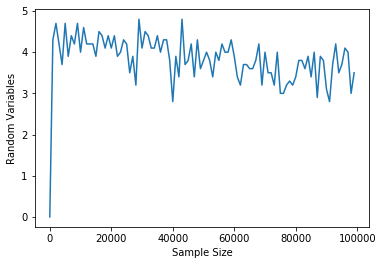

0.35


In [77]:
y, count = [], 0
it = [j for j in range(10, 100000, 1000)]
for i in range(10, 100000, 1000):
    count = 0
    for k in range(10):
        data_obj = GenerateDataset2()
        x_dataset, y_dataset = data_obj.generate(i)
        x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

        clf = DecisionTree2()
        clf.train(x_train, y_train)

        a = clf.check_irrelevant()
        count += a

    y.append(count/10)

plt.plot(it,y)
plt.xlabel("Sample Size")
plt.ylabel("Random Variables")
plt.show()

print(count/len(y))

ValueError: x and y must be the same size

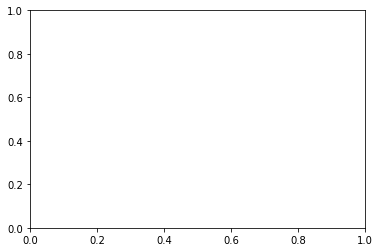

In [88]:
plt.scatter(it,y)
plt.xlabel("Sample Size")
plt.ylabel("Random Variables")
plt.show()

From the graph shown above, we can see that the threshold for sample size is around 1500. After that, we are getting over 50% error rate. This is because if we stop growing trees after for a large sample size, the probability to get random majority number is high. While if we have small sample sizes to prune on, most of our decision tree would be built already so this pruning would have little effect.

## Finding spurious data after pruning sample by depth

Average number of irrelevant variables in the decision tree: 3.6719999999999993
Average probability of including an irrelevant variable in the decision tree: 0.06019370314821661


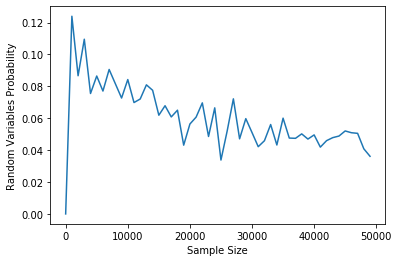

In [86]:
probability, count = [], []
it = [j for j in range(10, 50000, 1000)]
for i in range(10, 50000, 1000):
    count_prob, count_num = 0, 0
    for k in range(5):
        data_obj = GenerateDataset2()
        x_dataset, y_dataset = data_obj.generate(i)
        x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

        clf = DecisionTreeDepth(8)
        clf.train(x_train, y_train)

        irr_num = clf.check_irrelevant()
        count_num += irr_num
        ip = clf.check_irrelevant_probability()
        count_prob += ip
    count.append(count_num/5)
    probability.append(count_prob/5)
                  
print("Average number of irrelevant variables in the decision tree: {}".format(sum(count)/len(count)))
print("Average probability of including an irrelevant variable in the decision tree: {}".format(sum(probability)/len(probability)))

plt.plot(it,probability)
plt.xlabel("Sample Size")
plt.ylabel("Random Variables Probability")
plt.show()

From question 2), the average number of irrelevant data that was gotten was 6. But after pruning the decision tree by depth, that average reduced by a bit to $5.95$. So, this shows that the likelihood of spurious data decreases if we prune the tree by an optimal depth.

## Finding spurious data after pruning sample by sample size

In [53]:
y, count = [], 0
for i in range(0, 20):
    data_obj = GenerateDataset2()
    x_dataset, y_dataset = data_obj.generate(10000)
    x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

    clf = DecisionTreeSample(3500)
    clf.train(x_train, y_train)
    
    a = clf.check_irrelevant()
    count += a
    y.append(a)

    y_pred = clf.predict(x_test)
    acc = 100*error(y_test, y_pred)

print(count/len(y))

0.05


Average number of irrelevant variables in the decision tree: 0.684
Average probability of including an irrelevant variable in the decision tree: 0.03493041882215495


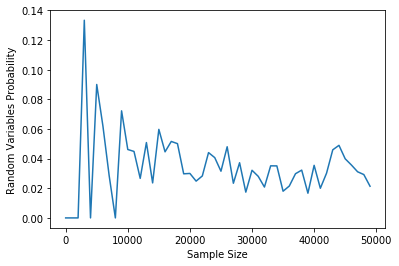

In [98]:
probability, count = [], []
it = [j for j in range(10, 50000, 1000)]
for i in range(10, 50000, 1000):
    count_prob, count_num = 0, 0
    for k in range(5):
        data_obj = GenerateDataset2()
        x_dataset, y_dataset = data_obj.generate(i)
        x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=1234)

        clf = DecisionTreeSample(1000)
        clf.train(x_train, y_train)

        irr_num = clf.check_irrelevant()
        count_num += irr_num
        ip = clf.check_irrelevant_probability()
        count_prob += ip
    count.append(count_num/5)
    probability.append(count_prob/5)
                  
print("Average number of irrelevant variables in the decision tree: {}".format(sum(count)/len(count)))
print("Average probability of including an irrelevant variable in the decision tree: {}".format(sum(probability)/len(probability)))

The number of spurious data reduces significantly from 6 when no pruning was applied to $0.2$ after pruning by sample size. We can therefore say that after applying pruning by sample size, we get much more optimized tree with respect to spurious data.

In [ ]:
plt.plot(it,probability)
plt.xlabel("Sample Size")
plt.ylabel("Random Variables Probability")
plt.show()